In [2]:
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
from hydra import compose, initialize
from hydra.utils import instantiate
import numpy as np
import pytorch_lightning as pl
import torch
from torch import Tensor
import torch.nn.functional as F
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
import galsim
from bliss.catalog import TileCatalog, get_is_on_from_n_sources, FullCatalog
from bliss.datasets.background import ConstantBackground
from bliss.datasets.sdss import convert_flux_to_mag
from bliss.models.galsim_decoder import SingleGalsimGalaxyDecoder,SingleGalsimGalaxyPrior,UniformGalsimGalaxiesPrior
from bliss.datasets.galsim_galaxies import GalsimBlends
from case_studies.coadds.signal_noise_ratio  import snr


In [15]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [4]:
def _add_noise_and_background(image: Tensor, background: Tensor) -> Tensor:
    image_with_background = image + background
    noise = image_with_background.sqrt() * torch.randn_like(image_with_background)
    return image_with_background + noise

def load_psf_from_file(psf_image_file: str, pixel_scale: float) -> galsim.GSObject:
    """Return normalized PSF galsim.GSObject from numpy psf_file."""
    assert Path(psf_image_file).suffix == ".npy"
    psf_image = np.load(psf_image_file)
    assert len(psf_image.shape) == 3 and psf_image.shape[0] == 1
    psf_image = galsim.Image(psf_image[0], scale=pixel_scale)
    return galsim.InterpolatedImage(psf_image).withFlux(1.0)

def _sample_n_sources(max_n_sources) -> int:
    return int(torch.randint(1, max_n_sources + 1, (1,)).int().item())

def _uniform(a, b, n_samples=1) -> Tensor:
    # uses pytorch to return a single float ~ U(a, b)
    return (a - b) * torch.rand(n_samples) + b

class CoaddUniformGalsimGalaxiesPrior(UniformGalsimGalaxiesPrior):
    def __init__(
        self,
        single_galaxy_prior: SingleGalsimGalaxyPrior,
        max_n_sources: int,
        max_shift: float,
        num_dithers: int,
    ):
        super().__init__(
            single_galaxy_prior,
            max_n_sources,
            max_shift,
        )
        
    def sample(self) -> Dict[str, Tensor]:
        """Returns a single batch of source parameters."""
        n_sources = _sample_n_sources(self.max_n_sources)

        params = torch.zeros(self.max_n_sources, self.dim_latents)
        params[:n_sources, :] = self.single_galaxy_prior.sample(n_sources)

        locs = torch.zeros(self.max_n_sources, 2)
        locs[:n_sources, 0] = _uniform(-self.max_shift, self.max_shift, n_sources) + 0.5
        locs[:n_sources, 1] = _uniform(-self.max_shift, self.max_shift, n_sources) + 0.5

        # for now, galaxies only
        galaxy_bools = torch.zeros(self.max_n_sources, 1)
        galaxy_bools[:n_sources, :] = 1
        star_bools = torch.zeros(self.max_n_sources, 1)

        dithers = [((-0.5 - 0.5) * torch.rand((2,)) + 0.5).numpy() for x in range(num_dithers)]

        return {
            "n_sources": torch.tensor(n_sources),
            "galaxy_params": params,
            "locs": locs,
            "galaxy_bools": galaxy_bools,
            "star_bools": star_bools,
            "dithers": dithers,
        }

class CoaddSingleGalaxyDecoder(SingleGalsimGalaxyDecoder):
    def __init__(
        self,
        slen: int,
        n_bands: int,
        pixel_scale: float,
    #    psf_image_file: str,
     ) -> None:
        assert n_bands == 1, "Only 1 band is supported"
        self.slen = slen
        self.n_bands = 1
        self.pixel_scale = pixel_scale
    #    self.psf = load_psf_from_file(psf_image_file, self.pixel_scale)
        
    def render_galaxy(
        self,
        galaxy_params: Tensor,
        psf: galsim.GSObject,
        slen: int,
        offset: Optional[Tensor] = None,
        dithers: Optional[Tensor] = None,
    ) -> Tensor:
        assert offset is None or offset.shape == (2,)
        if isinstance(galaxy_params, Tensor):
            galaxy_params = galaxy_params.cpu().detach()
        total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params
        bulge_frac = 1 - disk_frac

        disk_flux = total_flux * disk_frac
        bulge_flux = total_flux * bulge_frac

        components = []
        if disk_flux > 0:
            b_d = a_d * disk_q
            disk_hlr_arcsecs = np.sqrt(a_d * b_d)
            disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
                q=disk_q,
                beta=beta_radians * galsim.radians,
            )
            components.append(disk)
        if bulge_flux > 0:
            b_b = bulge_q * a_b
            bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
            bulge = galsim.DeVaucouleurs(
                flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs
            ).shear(q=bulge_q, beta=beta_radians * galsim.radians)
            components.append(bulge)
        galaxy = galsim.Add(components)
        gal_conv = galsim.Convolution(galaxy, psf)
        offset = (0,0) if offset is None else offset
        dithers = (0,0) if dithers is None else dithers
        shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
        shift = shift.reshape(1,2) if len(shift) == 2 else shift
        images = []
        for i in shift:
            image = gal_conv.drawImage(
                nx=slen, ny=slen, method="auto", scale=self.pixel_scale, offset=i
            )
            image = image.array
            images.append(image)
        return torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)

class FullCatalogDecoder:
    def __init__(
        self, single_galaxy_decoder: CoaddSingleGalaxyDecoder, slen: int, bp: int
    ) -> None:
        self.single_decoder = single_galaxy_decoder
        self.slen = slen
        self.bp = bp
        assert self.slen + 2 * self.bp >= self.single_decoder.slen

    def __call__(self, full_cat: FullCatalog):
        return self.render_catalog(full_cat, self.single_decoder.psf)

    def render_catalog(self, full_cat: FullCatalog, psf: galsim.GSObject, dithers: Optional[Tensor]):
        size = self.slen + 2 * bp
        full_plocs = full_cat.plocs
        b, max_n_sources, _ = full_plocs.shape

        image = torch.zeros(len(dithers), 1, size, size)
        image0 = torch.zeros(1, size, size)
        noiseless_centered = torch.zeros(len(dithers), max_n_sources, 1, size, size)
        noiseless_uncentered = torch.zeros(len(dithers), max_n_sources, 1, size, size)

        n_sources = int(full_cat.n_sources[0].item())
        galaxy_params = full_cat["galaxy_params"][0]
        plocs = full_plocs[0]

        for ii in range(n_sources):
            offset_x = plocs[ii][1] + bp - size / 2
            offset_y = plocs[ii][0] + bp - size / 2
            offset = torch.tensor([offset_x, offset_y])
            centered = self.single_decoder.render_galaxy(galaxy_params[ii], psf, size, dithers = dithers)
            uncentered = self.single_decoder.render_galaxy(galaxy_params[ii], psf, size, offset)
            uncentered_dithered = self.single_decoder.render_galaxy(galaxy_params[ii], psf, size, offset, dithers)
            noiseless_centered[:,ii] = centered.reshape(centered.shape[0], 1, size, size)
            noiseless_uncentered[:,ii] = uncentered.reshape(uncentered.shape[0], 1, size, size)
            image0 += uncentered
            image += uncentered_dithered
        return image, noiseless_centered, noiseless_uncentered, image0


class CoaddGalsimBlends(GalsimBlends):
    """Dataset of coadd galsim blends."""

    def __init__(self,
        prior: UniformGalsimGalaxiesPrior,
        decoder: FullCatalogDecoder,
        background: ConstantBackground,
        tile_slen: int,
        max_sources_per_tile: int,
        num_workers: int,
        batch_size: int,
        n_batches: int,
        fix_validation_set: bool = False,
        valid_n_batches: Optional[int] = None,
    ):
        super().__init__(
            prior,
            decoder,
            background,
            tile_slen,
            max_sources_per_tile,
            num_workers,
            batch_size,
            n_batches,
            fix_validation_set,
            valid_n_batches,
        )
        self.prior = prior
        self.decoder = decoder
        self.n_batches = n_batches
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.background = background
        self.fix_validation_set = fix_validation_set
        self.valid_n_batches = valid_n_batches
        
        self.slen = self.decoder.slen
        self.pixel_scale = self.decoder.single_decoder.pixel_scale
        

    def _get_images(self, full_cat, dithers):
        size = self.slen + 2 * self.bp # check bp gets passed through
        psf_obj = self.psf.sample()
        noiseless, noiseless_centered, noiseless_uncentered, image0 = FullCatalogDecoder.render_catalog(
            full_cat, psf_obj, dithers
        )

        # get background and noisy image.
        background = background.sample((1, *noiseless.reshape(len(dithers),size,size).shape)).squeeze(0).reshape(len(dithers),1,size,size)
        noisy_image = _add_noise_and_background(noiseless, background)

        # align single exposures
        aligned_images = align_single_exposures(image0[:].reshape(size,size), noisy_image, size, dithers)
        
        # get snr
        bg = background[:,:, 1:size-1, 1:size-1]
        img = aligned_images.reshape(len(dithers),1,size-2,size-2)
        snr_images = snr(img, bg)

        # coadd images
        cropped_background = background.reshape(len(dithers),size,size)[:,1:size-1, 1:size-1] 
        coadded_image = linear_coadd(aligned_images, cropped_background)

        return noisy_image, noiseless, noiseless_centered, noiseless_uncentered, background, snr_images, coadded_image

    def _add_metrics(
        self,
        full_cat: FullCatalog,
    ):
        return full_cat




In [5]:
with initialize(config_path="../sdss_galaxies/config"):
    cfg = compose("config", overrides=[])

In [6]:
prior = instantiate(cfg.datasets.sdss_galaxies.prior) 
decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
n_batches = 1
max_n_sources = 1
max_shift = 0.5
num_dithers = 4
mprior = instantiate(cfg.models.prior)
tile_catalog = mprior.sample_prior(tile_slen=4, batch_size=3, n_tiles_h=2, n_tiles_w=2)
full_catalog = TileCatalog.to_full_params(tile_catalog)

In [7]:
# Test CUGGP
cuggp = CoaddUniformGalsimGalaxiesPrior(prior, max_n_sources, max_shift, num_dithers)


In [45]:
pixel_scale = 0.393
cuggprior = cuggp.sample() # does not work if we use galsim_blended_galaxies for prior config
n_sources = cuggprior["n_sources"]
galaxy_params = cuggprior["galaxy_params"]
locs = cuggprior["locs"]
galaxy_bools = cuggprior["galaxy_bools"]
star_bools = cuggprior["star_bools"]
dithers = cuggprior["dithers"]
offset = None
psf = decoder.psf


In [46]:
dithers

[array([0.40698195, 0.35111105], dtype=float32),
 array([0.18484151, 0.4421649 ], dtype=float32),
 array([ 0.29798478, -0.3029046 ], dtype=float32),
 array([-0.42174256,  0.07150775], dtype=float32)]

In [9]:
csgd = CoaddSingleGalaxyDecoder(decoder, n_bands = 1, pixel_scale = pixel_scale)
csgd.render_galaxy(galaxy_params = galaxy_params[0], slen = decoder.slen, psf = decoder.psf, offset = offset, dithers = dithers)

/tmp/ipykernel_156891/1980006849.py:119: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))


tensor([[[[0.0219, 0.0229, 0.0239,  ..., 0.0130, 0.0123, 0.0117],
          [0.0239, 0.0251, 0.0262,  ..., 0.0142, 0.0134, 0.0127],
          [0.0261, 0.0274, 0.0288,  ..., 0.0155, 0.0146, 0.0138],
          ...,
          [0.0155, 0.0164, 0.0174,  ..., 0.0306, 0.0291, 0.0277],
          [0.0142, 0.0150, 0.0159,  ..., 0.0280, 0.0267, 0.0254],
          [0.0130, 0.0137, 0.0145,  ..., 0.0255, 0.0244, 0.0233]]],


        [[[0.0221, 0.0231, 0.0241,  ..., 0.0128, 0.0122, 0.0115],
          [0.0241, 0.0253, 0.0264,  ..., 0.0140, 0.0133, 0.0126],
          [0.0264, 0.0277, 0.0290,  ..., 0.0153, 0.0144, 0.0137],
          ...,
          [0.0157, 0.0166, 0.0176,  ..., 0.0304, 0.0289, 0.0274],
          [0.0144, 0.0152, 0.0161,  ..., 0.0277, 0.0264, 0.0252],
          [0.0132, 0.0139, 0.0147,  ..., 0.0253, 0.0242, 0.0231]]],


        [[[0.0229, 0.0240, 0.0250,  ..., 0.0141, 0.0133, 0.0126],
          [0.0250, 0.0262, 0.0275,  ..., 0.0154, 0.0145, 0.0137],
          [0.0272, 0.0286, 0.0301,  ..

In [10]:
prior = instantiate(cfg.datasets.galsim_blended_galaxies.prior) 
decoder = instantiate(cfg.datasets.galsim_blended_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 1000
n_batches = 1
full_catalog = CoaddGalsimBlends(prior = prior, decoder = decoder, background = background, tile_slen = tile_slen, max_sources_per_tile = max_tile_n_sources, num_workers = num_workers, batch_size = batch_size, n_batches = n_batches)._sample_full_catalog()

In [11]:
slen = 40
bp = 24
fcdecoder = FullCatalogDecoder(decoder, slen, bp)
fcdecoder.render_catalog(full_catalog, psf, dithers) # Do I need to change the target in config to bliss.case_study.coadd.coadd_decoder?

AttributeError: 'FullCatalogDecoder' object has no attribute 'render_galaxy'

In [48]:
dithers

[array([ 0.2863866, -0.2431587], dtype=float32),
 array([0.45234668, 0.29335123], dtype=float32),
 array([0.26052737, 0.14739156], dtype=float32),
 array([-0.45585835,  0.38580644], dtype=float32)]

In [12]:
total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params[0]
bulge_frac = 1 - disk_frac

disk_flux = total_flux * disk_frac
bulge_flux = total_flux * bulge_frac

components = []
if disk_flux > 0:
    b_d = a_d * disk_q
    disk_hlr_arcsecs = np.sqrt(a_d * b_d)
    disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
        q=disk_q,
        beta=beta_radians * galsim.radians,
    )
    components.append(disk)
if bulge_flux > 0:
    b_b = bulge_q * a_b
    bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
    bulge = galsim.DeVaucouleurs(
        flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs
    ).shear(q=bulge_q, beta=beta_radians * galsim.radians)
    components.append(bulge)
galaxy = galsim.Add(components)
gal_conv = galsim.Convolution(galaxy, psf)
offset = (0,0) if offset is None else offset
dithers = (0,0) if dithers is None else dithers
shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
shift = shift.reshape(1,2) if len(shift) == 2 else shift
images = []
for i in shift:
    image = gal_conv.drawImage(
        nx=slen, ny=slen, method="auto", scale=pixel_scale, offset=i
    )
    image = image.array
    images.append(image)
torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)


tensor([[[[0.0567, 0.0598, 0.0629,  ..., 0.0357, 0.0335, 0.0314],
          [0.0632, 0.0670, 0.0708,  ..., 0.0400, 0.0373, 0.0348],
          [0.0705, 0.0751, 0.0797,  ..., 0.0447, 0.0416, 0.0387],
          ...,
          [0.0446, 0.0482, 0.0520,  ..., 0.0864, 0.0808, 0.0755],
          [0.0400, 0.0430, 0.0463,  ..., 0.0769, 0.0723, 0.0679],
          [0.0360, 0.0385, 0.0412,  ..., 0.0685, 0.0647, 0.0610]]],


        [[[0.0572, 0.0603, 0.0635,  ..., 0.0353, 0.0330, 0.0309],
          [0.0639, 0.0677, 0.0715,  ..., 0.0394, 0.0368, 0.0343],
          [0.0713, 0.0759, 0.0806,  ..., 0.0441, 0.0410, 0.0381],
          ...,
          [0.0454, 0.0489, 0.0528,  ..., 0.0854, 0.0798, 0.0745],
          [0.0407, 0.0437, 0.0470,  ..., 0.0761, 0.0715, 0.0671],
          [0.0365, 0.0391, 0.0418,  ..., 0.0678, 0.0640, 0.0604]]],


        [[[0.0598, 0.0633, 0.0669,  ..., 0.0396, 0.0370, 0.0346],
          [0.0666, 0.0708, 0.0752,  ..., 0.0444, 0.0413, 0.0385],
          [0.0741, 0.0792, 0.0845,  ..

In [13]:
size = decoder.slen + 2 * bp
full_plocs = full_catalog.plocs
b, max_n_sources, _ = full_plocs.shape

image = torch.zeros(len(dithers), 1, size, size)
noiseless_centered = torch.zeros(max_n_sources, len(dithers), size, size)
noiseless_uncentered = torch.zeros(max_n_sources, len(dithers), size, size)

n_sources = int(full_catalog.n_sources[0].item())
galaxy_params = full_catalog["galaxy_params"][0]
plocs = full_plocs[0]

for ii in range(n_sources):
    offset_x = plocs[ii][1] + bp - size / 2
    offset_y = plocs[ii][0] + bp - size / 2
    offset = torch.tensor([offset_x, offset_y])
    centered = csgd.render_galaxy(galaxy_params[ii], psf, size, dithers = dithers)
    uncentered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset, dithers)
    noiseless_centered[ii] = centered.reshape(centered.shape[0], size, size)
    noiseless_uncentered[ii] = uncentered.reshape(uncentered.shape[0], size, size)
    image += uncentered

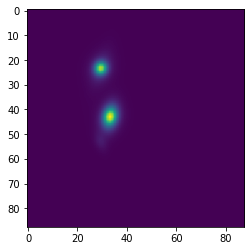

In [16]:
plt.imshow(image[2].reshape(image[2].shape[1],image[2].shape[2]).numpy())

In [17]:
centered.reshape(centered.shape[0], size, size).shape

torch.Size([4, 88, 88])

In [29]:
noiseless_uncentered.shape

torch.Size([6, 4, 88, 88])

In [32]:
noiseless_centered.shape

torch.Size([4, 6, 1, 88, 88])

In [18]:
image = torch.zeros(len(dithers), 1, size, size)
image0 = torch.zeros(1, 1, size, size)
noiseless_centered = torch.zeros(len(dithers), max_n_sources, 1, size, size)
noiseless_uncentered = torch.zeros(len(dithers), max_n_sources, 1, size, size)

n_sources = int(full_catalog.n_sources[0].item())
galaxy_params = full_catalog["galaxy_params"][0]
plocs = full_plocs[0]

for ii in range(n_sources):
    offset_x = plocs[ii][1] + bp - size / 2
    offset_y = plocs[ii][0] + bp - size / 2
    offset = torch.tensor([offset_x, offset_y])
    centered = csgd.render_galaxy(galaxy_params[ii], psf, size, dithers = dithers)
    uncentered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset)
    uncentered_dithered = csgd.render_galaxy(galaxy_params[ii], psf, size, offset, dithers)
    noiseless_centered[:,ii] = centered.reshape(centered.shape[0], 1, size, size)
    noiseless_uncentered[:,ii] = uncentered.reshape(uncentered.shape[0], 1, size, size)
    image0 += uncentered
    image += uncentered_dithered

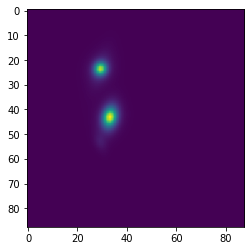

In [19]:
plt.imshow(image0[:].reshape(image0[:].shape[2],image0[:].shape[3]).numpy())

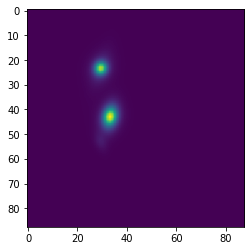

In [20]:
plt.imshow(image[2].reshape(image[2].shape[1],image[2].shape[2]).numpy())

In [21]:
# check noise and dither independence
background = instantiate(cfg.datasets.sdss_galaxies.background)
background = background.sample((1, *image.reshape(len(dithers),size,size).shape)).squeeze(0).reshape(len(dithers),1,size,size)
_add_noise_and_background(image, background)

image_with_background = image + background
noise = image_with_background.sqrt() * torch.randn_like(image_with_background) # randomized by value of Tensor
noisy_image = image_with_background + noise

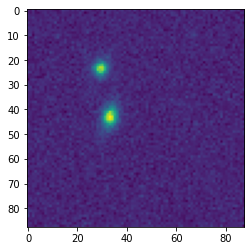

In [22]:
plt.imshow(noisy_image[2].reshape(noisy_image[2].shape[1],noisy_image[2].shape[2]).numpy())

In [23]:
i0 = galsim.Image(np.array(image0[:].reshape(88,88)), wcs=galsim.PixelScale(pixel_scale))
i1 = galsim.Image(np.array(image[:][0].reshape(88,88)))

In [24]:
from bliss.models.decoder import get_mgrid
def align_single_exposures(img0, img1, slen, dithers, scale = 0.393):
    """Aligns multiple single exposure images that are dithered by some sub-pixel amount.
    Args:
        img0: Galsim image object
        img1: Tensor of shape `(N x C x H x W)` where N is the number of dithers (len(dithers)), \
            C is the number of band, H is height and W is weight, containing image data.
        slen: size of images (H and W)
        dithers: List of pairs of sub-pixel amounts that img0 is shifted by in x and y directions
        scale: pixel_scale
    Returns:
        Tensor of shape `(N x H-2 x W-2)`. Aligned images with 1 pixel cropped from from each \
            direction of height and width.
    """
    img0 = galsim.Image(np.array(img0), wcs=galsim.PixelScale(pixel_scale)) 
    wcs0 = img0.wcs
    images = img1

    sgrid = (get_mgrid(slen) - (-1))/2 * (slen)
    sgrid = sgrid.reshape(slen**2,2)
    grid_x = wcs0.xyTouv(sgrid[:,0],sgrid[:,1])[0]
    grid_y = wcs0.xyTouv(sgrid[:,0],sgrid[:,1])[1]

    grid = torch.empty(size=(0, 2))
    for i in dithers:
        wcs1 = galsim.OffsetWCS(scale = scale, origin = galsim.PositionD(i))
        x, y = wcs1.uvToxy(grid_x,grid_y)
        x_grid = (x/slen) * 2 + (-1)
        y_grid = (y/slen) * 2 + (-1)
        grid = torch.cat([grid, torch.stack((torch.tensor(x_grid),torch.tensor(y_grid)),-1)], dim=0)

    iplots = []
    input = torch.tensor(images[:]).reshape(len(dithers),1,slen,slen).float()
    grids = grid.reshape(len(dithers),1,slen*slen,2).float()
    iplots.append(F.grid_sample(input, grids, align_corners = False))

    # reshape and crop 1 pixel on each side
    iplots = torch.tensor(iplots[:][0]).reshape(len(dithers),slen,slen)
    iplots_cropped = iplots[:,1:slen-1,1:slen-1]
    return iplots_cropped

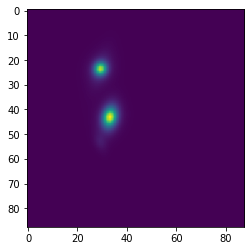

In [27]:
plt.imshow(image0[:].reshape(size,size).numpy())

In [28]:
# Add alignment and coadding 
img0 = image0[:].reshape(size,size)
imgs = noisy_image
aligned_images = align_single_exposures(img0, imgs, size, dithers)

/tmp/ipykernel_156891/2574139102.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [grid, torch.stack((torch.tensor(x_grid), torch.tensor(y_grid)), -1)], dim=0
/tmp/ipykernel_156891/2574139102.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images[:]).reshape(len(dithers), 1, slen, slen).float()
/tmp/ipykernel_156891/2574139102.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  iplots = torch.tensor(iplots[:][0]).reshape(len(dithers), slen, slen)


In [29]:
img0 = galsim.Image(np.array(img0), wcs=galsim.PixelScale(pixel_scale)) 
wcs0 = img0.wcs
images = imgs


In [30]:
sgrid = (get_mgrid(size) - (-1))/2 * (size)
sgrid = sgrid.reshape(size**2,2)
grid_x = wcs0.xyTouv(sgrid[:,0],sgrid[:,1])[0]
grid_y = wcs0.xyTouv(sgrid[:,0],sgrid[:,1])[1]

grid = torch.empty(size=(0, 2))
for i in dithers:
    wcs1 = galsim.OffsetWCS(scale = pixel_scale, origin = galsim.PositionD(i))
    x, y = wcs1.uvToxy(grid_x,grid_y)
    x_grid = (x/size) * 2 + (-1)
    y_grid = (y/size) * 2 + (-1)
    grid = torch.cat([grid, torch.stack((torch.tensor(x_grid),torch.tensor(y_grid)),-1)], dim=0)


/tmp/ipykernel_156891/3371014255.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.cat([grid, torch.stack((torch.tensor(x_grid), torch.tensor(y_grid)), -1)], dim=0)


In [31]:
iplots = []
input = torch.tensor(images[:]).reshape(len(dithers),1,size,size).float()
grids = grid.reshape(len(dithers),1,size**2,2).float()
iplots.append(F.grid_sample(input, grids, align_corners = False))

/tmp/ipykernel_156891/793225213.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images[:]).reshape(len(dithers), 1, size, size).float()


In [32]:
torch.tensor(iplots[:][0]).reshape(len(dithers),size,size)[:,1:size-1,1:size-1]

/tmp/ipykernel_156891/3359810218.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(iplots[:][0]).reshape(len(dithers), size, size)[:, 1 : size - 1, 1 : size - 1]


tensor([[[888.0155, 877.4764, 874.2484,  ..., 849.4955, 836.3114, 853.0780],
         [891.4829, 857.4700, 860.5918,  ..., 853.9618, 862.1401, 855.5275],
         [884.4193, 858.6255, 837.2758,  ..., 868.4943, 882.1550, 875.8517],
         ...,
         [866.7104, 861.4074, 851.3232,  ..., 846.3796, 860.8678, 888.2444],
         [861.7330, 875.7976, 856.6984,  ..., 835.8403, 842.8138, 871.4930],
         [848.8041, 861.1249, 857.4638,  ..., 844.9465, 841.4750, 856.0826]],

        [[867.3607, 831.1862, 853.5082,  ..., 881.6722, 870.3297, 858.9865],
         [891.2095, 856.0781, 853.2266,  ..., 884.8448, 877.7802, 851.6365],
         [889.3782, 869.8191, 866.3290,  ..., 884.8408, 877.8563, 865.7223],
         ...,
         [848.5818, 846.1994, 849.6868,  ..., 878.1140, 865.0913, 847.1288],
         [853.5518, 821.0460, 846.2291,  ..., 850.0447, 866.4307, 879.0674],
         [881.6307, 855.5946, 824.7090,  ..., 855.3325, 870.9373, 881.0297]],

        [[830.6999, 879.4776, 816.4354,  ...

In [133]:
aligned_images

tensor([[[864.8862, 880.0833, 890.7655,  ..., 881.4109, 895.9703, 875.0217],
         [896.9274, 864.4228, 828.5861,  ..., 842.2588, 882.7982, 856.4287],
         [871.0705, 885.4985, 838.5040,  ..., 882.3884, 882.1046, 910.1583],
         ...,
         [871.1431, 871.6219, 853.9985,  ..., 886.3763, 851.1091, 833.2911],
         [854.2748, 863.6624, 864.2234,  ..., 868.0827, 838.8348, 833.5297],
         [843.3568, 839.2103, 855.2067,  ..., 855.0002, 859.7249, 868.8317]],

        [[860.0744, 866.3655, 841.0487,  ..., 845.0515, 849.3624, 843.9888],
         [873.1684, 851.7743, 857.2377,  ..., 870.2887, 863.9237, 849.0753],
         [879.6937, 857.2256, 894.5875,  ..., 868.4433, 876.3151, 846.5569],
         ...,
         [842.2479, 868.2714, 862.8747,  ..., 890.5851, 856.3481, 831.3811],
         [855.5215, 870.8060, 830.2527,  ..., 861.7773, 848.3145, 834.4565],
         [862.7029, 864.6052, 864.1152,  ..., 815.9521, 838.3801, 846.1824]],

        [[876.8278, 859.3868, 872.3575,  ...

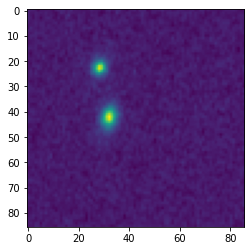

In [33]:
plt.imshow(aligned_images[0].numpy())

In [39]:
# test_align assert sizes
pixel_scale = 0.393
slen = 9
g0 = galsim.Gaussian(sigma=1.0)
g0 = g0.shear(e1=0, e2=0)
img0 = g0.drawImage(nx=slen, ny=slen, scale=pixel_scale, bandpass=None)
img0 = img0.array
ds = [((-0.5 - 0.5) * torch.rand((2,)) + 0.5).numpy() for x in range(10)]
img = []
for i in ds:
    im = g0.drawImage(nx=slen, ny=slen, scale=pixel_scale, offset=i, bandpass=None)
    im = im.array
    img.append(im)
align_single_exposures(img0, img, slen, ds).shape == torch.Size([len(ds), slen - 2, slen - 2])

/tmp/ipykernel_156891/2574139102.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [grid, torch.stack((torch.tensor(x_grid), torch.tensor(y_grid)), -1)], dim=0
/tmp/ipykernel_156891/2574139102.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  iplots = torch.tensor(iplots[:][0]).reshape(len(dithers), slen, slen)


True

In [42]:
aligned_images.shape

torch.Size([4, 86, 86])

In [47]:
# add snr
bg = background[:,:, 1:size-1, 1:size-1]
img = aligned_images.reshape(len(dithers),1,size-2,size-2)
img - bg
torch.sqrt(torch.sum((img - bg)**2 / (img - bg + bg), dim=(3, 2, 1)))
snr(img, bg)

tensor([5060.1855, 5060.1177, 5060.3608, 5060.1235])

In [50]:
torch.mean(img, dim=(3, 2, 1)) / torch.std(img, dim=(3, 2, 1))

tensor([17.3391, 17.7439, 16.6246, 17.8100])

In [130]:
# Coadd using direct coadd: linear combination 
# Direct coadd, where weights are proportional to inverse variance
bd = background.reshape(len(dithers),size,size)[:,1:size-1, 1:size-1] # background cropped
id = torch.tensor(aligned_images) - bd # aligned images without background
weight = 1 / torch.tensor(aligned_images)
num = torch.sum(id / torch.tensor(aligned_images), dim = 0)
coadded = num / (torch.sum(weight, dim = 0))

def linear_coadd(aligned_images, cropped_background):
    assert torch.tensor(aligned_images).shape == torch.tensor(cropped_background).shape

    id = torch.tensor(aligned_images) - cropped_background 
    weight = 1 / torch.tensor(aligned_images)
    num = torch.sum(id / torch.tensor(aligned_images), dim = 0)
    return num / (torch.sum(weight, dim = 0))


In [131]:
linear_coadd(aligned_images, bd)

/tmp/ipykernel_1476522/3013547580.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  assert torch.tensor(aligned_images).shape == torch.tensor(cropped_background).shape


tensor([[-14.4965,   5.7448,  15.6396,  ...,   9.7780,  11.7710,   0.6030],
        [  5.5216,   2.2028,   8.4663,  ...,  -5.4049,  -2.6983, -17.1500],
        [ 15.7054,  11.8200,  -3.8945,  ...,  -0.3650,   3.6645,  -0.4348],
        ...,
        [-19.0546,  -7.2267,  -4.5730,  ...,   7.0405, -22.6021, -22.1054],
        [  3.1368, -11.8408,  -3.5431,  ...,  -1.0711,  -5.2976,   8.3232],
        [-21.7410,  -2.5716,  -7.8379,  ...,   1.4767, -19.2051,  -1.5259]])

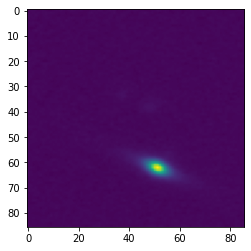

In [129]:
plt.imshow(coadded.numpy())

In [142]:
bd.shape

torch.Size([4, 86, 86])